# Sales analysis for Vorelec LLC
### Business reports from Amazon seller account were analysed. Apache Spark and Pandas were used.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import round, expr
from pyspark.sql.types import StructType, StructField, StringType
import pandas as pd
from datetime import date
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
spark = (SparkSession.builder.appName("Vorelec").getOrCreate())

In [3]:
path2 = "./BusinessReport-2-18-22.csv"
sales_df = spark.read.format("csv").option ("header", True).option("inferSchema",True).load(path2)
sales_df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Ordered Product Sales: string (nullable = true)
 |-- Units Ordered: integer (nullable = true)
 |-- Total Order Items: integer (nullable = true)
 |-- Average Sales per Order Item: string (nullable = true)
 |-- Average Units per Order Item: double (nullable = true)
 |-- Average Selling Price: string (nullable = true)
 |-- Sessions: integer (nullable = true)
 |-- Order Item Session Percentage: string (nullable = true)
 |-- Average Offer Count: integer (nullable = true)



In [4]:
path3 = "./AdsLog.csv"
ads_df = spark.read.format("csv").option ("header", True).option("inferSchema",True).load(path3)
ads_df.printSchema()

root
 |-- country: string (nullable = true)
 |-- start: string (nullable = true)
 |-- stopped: string (nullable = true)
 |-- Platform: string (nullable = true)
 |-- description: string (nullable = true)
 |-- daily budget: string (nullable = true)
 |-- result: string (nullable = true)
 |-- spent: double (nullable = true)



In [5]:
ads_df.select("start","stopped" ,"spent").show(3)

+---------+---------+------+
|    start|  stopped| spent|
+---------+---------+------+
|5/11/2021|6/20/2021|514.01|
|5/31/2021| 6/7/2021| 92.97|
|5/21/2021|6/20/2021|  95.1|
+---------+---------+------+
only showing top 3 rows



In [6]:
sales_df.select("Date", col("Total Order Items").alias("Ordered"), 'Sessions').show(3)

+------+-------+--------+
|  Date|Ordered|Sessions|
+------+-------+--------+
|2/2/21|      0|       0|
|2/3/21|      0|       0|
|2/4/21|      0|       0|
+------+-------+--------+
only showing top 3 rows



In [7]:
sales_pd = sales_df.select("Date", col("Total Order Items").alias("Ordered"), 'Sessions').toPandas()

In [8]:
### to make time uniform for both sales_pd and ads_pd, translating all in one time format - pandas timestamp
sales_pd['Date'] = pd.to_datetime(sales_pd['Date'])

In [9]:
### need to do same or ads_pd, but first change str "current" to the max sales date

In [10]:
ads_pd=ads_df.filter(col("country") == "USA").select("start","stopped" ,"spent", "description").toPandas() ## just USA
ads_pd['start']=ads_pd['start'].apply(lambda x: last_date if x=='current'  else x)
ads_pd['stopped']=ads_pd['stopped'].apply(lambda x: last_date if x=='current'  else x)

In [11]:
last_date = sales_pd["Date"].to_list()[-1]
last_date

Timestamp('2022-02-17 00:00:00')

In [12]:
ads_pd['start'] = pd.to_datetime(ads_pd['start'])
ads_pd['stopped'] = pd.to_datetime(ads_pd['stopped'])
ads_pd['spent_per_day'] = ((ads_pd['stopped']-ads_pd['start']).dt.days)/ads_pd['spent']
ads_pd.head()

,start,stopped,spent,description,spent_per_day
0,2021-05-11,2021-06-20,514.01,GettingRidOfRev1 - Ad group1,0.077819
1,2021-05-31,2021-06-07,92.97,GettingRidOfRev1 - headphones_increasing_bids,0.075293
2,2021-05-21,2021-06-20,95.10,GettingRidOfRev1 - audio mixer,0.315457
3,2021-05-15,2021-06-20,388.83,Showing_with_just_mixer - Ad group1,0.092585
4,2021-11-22,2022-01-14,195.44,claim100 - gadget gift,0.271183


In [13]:
### we will plot sales as line (or scutter) 
### and in the same time scale we will plon lines from date ad started to stopped,
### spent_per_day will be the hue, to show how agressively we advertised
### each ad is a new line, with x1 = start date index of sales_df, x2 - stopped date index of sales_df,
### y = index of ads_pd
### so, new pandas DF is to created - 

In [15]:
sales_pd_with_campains = sales_pd.drop(columns = ["Sessions"]).copy()
spend_per_day_campains = sales_pd.drop(columns = ["Sessions"]).copy()

#to plot "bar" lines on top of sales plot, assing y = y+max(sales)
max_sales = sales_pd_with_campains["Ordered"].max()
num_campains = ads_pd.shape[0]
campains = ads_pd["description"].to_list()

# put everything in the loop

ads_pd_ind = 0
for c in campains:
    sales_pd_with_campains[c] = np.NaN
    spend_per_day_campains[c] = np.NaN
    from_ind = sales_pd_with_campains.loc[sales_pd_with_campains['Date'] == ads_pd.loc[ads_pd_ind, 'start']].index[0]
    to_ind = sales_pd_with_campains.loc[sales_pd_with_campains['Date'] == ads_pd.loc[ads_pd_ind, 'stopped']].index[0]
    sales_pd_with_campains.loc[(sales_pd_with_campains.index > from_ind) 
                           & (sales_pd_with_campains.index < to_ind), c] = max_sales+ads_pd_ind/5
    spend_per_day_campains.loc[(spend_per_day_campains.index > from_ind) 
                           & (spend_per_day_campains.index < to_ind), c] = ads_pd.loc[ads_pd_ind, 'spent_per_day'] #hue
    
    ads_pd_ind+=1
spend_pd = spend_per_day_campains.drop(columns = ["Ordered", 'Date'])
spend_pd['Spent, $ per day'] = spend_pd.sum(axis = 1)    
sales_pd_with_campains.describe()

,Ordered,GettingRidOfRev1 - Ad group1,GettingRidOfRev1 - headphones_increasing_bids,GettingRidOfRev1 - audio mixer,Showing_with_just_mixer - Ad group1,claim100 - gadget gift,with_just_mixer,audio mixer - audio mixer,Sound_mixer_kw - Ad group 1,Wood bkgr,guy,gift
count,381.000000,39.0,6.0,2.900000e+01,3.500000e+01,5.200000e+01,7.0,6.0,1.100000e+01,6.0,4.0,1.700000e+01
mean,0.485564,4.0,4.2,4.400000e+00,4.600000e+00,4.800000e+00,5.0,5.2,5.400000e+00,6.0,5.8,6.200000e+00
std,0.759450,0.0,0.0,1.807799e-15,2.703436e-15,5.381063e-15,0.0,0.0,9.315294e-16,0.0,0.0,1.831027e-15
min,0.000000,4.0,4.2,4.400000e+00,4.600000e+00,4.800000e+00,5.0,5.2,5.400000e+00,6.0,5.8,6.200000e+00
25%,0.000000,4.0,4.2,4.400000e+00,4.600000e+00,4.800000e+00,5.0,5.2,5.400000e+00,6.0,5.8,6.200000e+00
50%,0.000000,4.0,4.2,4.400000e+00,4.600000e+00,4.800000e+00,5.0,5.2,5.400000e+00,6.0,5.8,6.200000e+00
75%,1.000000,4.0,4.2,4.400000e+00,4.600000e+00,4.800000e+00,5.0,5.2,5.400000e+00,6.0,5.8,6.200000e+00
max,4.000000,4.0,4.2,4.400000e+00,4.600000e+00,4.800000e+00,5.0,5.2,5.400000e+00,6.0,5.8,6.200000e+00


<AxesSubplot:label='5131a187-fd01-458d-9f44-6fe88170c1e4', ylabel='Spent, $ per day'>

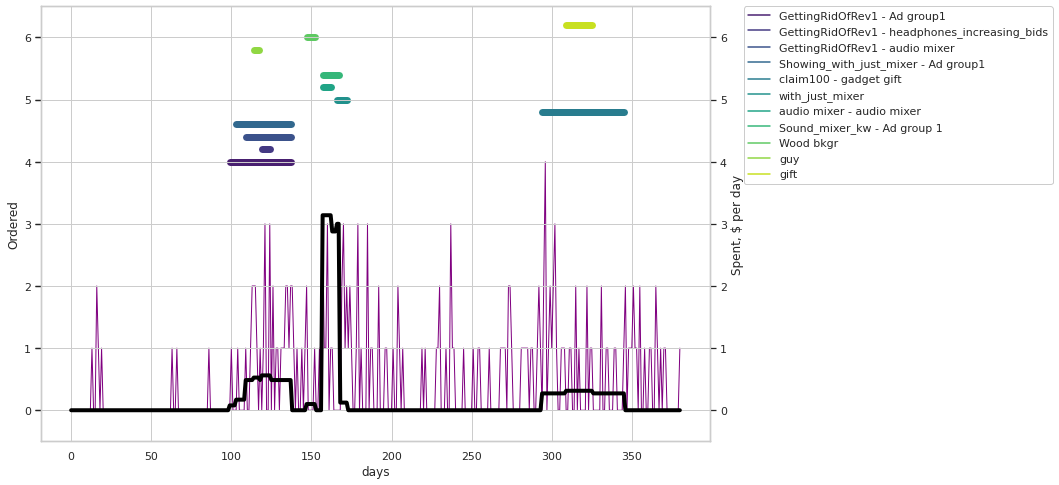

In [38]:
ax1 = sn.set_style(style=None, rc=None )
sn.set_theme(style = "whitegrid")
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.set(ylim=(-0.5, 6.5))
sn.lineplot(data = sales_pd_with_campains.drop(columns = "Ordered")
            , dashes=False, palette="viridis", ax=ax1, linewidth= 7)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. , framealpha = 1)
ax1.set(xlabel='days')
ax1.set(yticklabels=[])

ax2 = ax1.twinx()
ax2.set(ylim=(-.5, 6.5))
sn.lineplot(data = sales_pd_with_campains["Ordered"], ax=ax2, color='purple', linewidth = 1)
ax2.yaxis.set_label_position("left")
ax2.yaxis.set_ticks_position("left")

ax3 = ax1.twinx()
ax3.set(ylim=(-.5, 6.5))
sn.lineplot(data = spend_pd['Spent, $ per day'], ax=ax3, color='black', linewidth = 4)

##  last tree month - how much spent by day

Oct31 2020 - last_date

In [17]:
spons_time_file = 'Sponsored Products Performance Over Time reportOct31Jan29.xlsx'

In [18]:
spons_time = pd.read_excel(spons_time_file).set_index('Date')
spons_time.head()

/home/vera/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Clicks,Cost Per Click (CPC),Spend
Date,,,
2021-11-22,1,1.010,1.01
2021-11-23,2,2.705,5.41
2021-11-24,4,1.405,5.62
2021-11-25,2,2.955,5.91
2021-11-26,2,0.600,1.20


In [19]:
from_date = pd.Timestamp('2021-11-22')
to_date = last_date

In [20]:
sales_pd_last3m = sales_pd.loc[sales_pd['Date']>= from_date].set_index('Date') #.drop('index')
sales_pd_last3m = pd.concat([sales_pd_last3m, spons_time], axis= 1).replace(np.nan, 0)
sales_pd_last3m

,Ordered,Sessions,Clicks,Cost Per Click (CPC),Spend
Date,,,,,
2021-11-22,1,22,1.0,1.010,1.01
2021-11-23,0,9,2.0,2.705,5.41
2021-11-24,2,7,4.0,1.405,5.62
2021-11-25,4,8,2.0,2.955,5.91
2021-11-26,0,10,2.0,0.600,1.20
...,...,...,...,...,...
2022-02-13,0,7,0.0,0.000,0.00
2022-02-14,0,2,0.0,0.000,0.00
2022-02-15,0,3,0.0,0.000,0.00


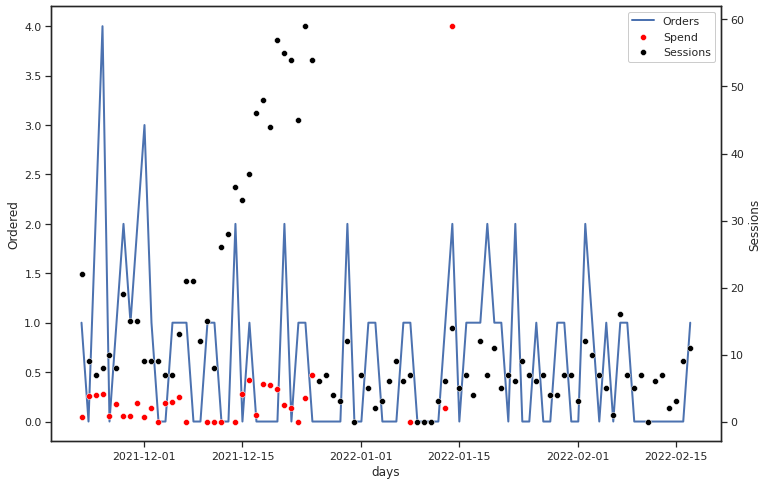

In [35]:
#ax1 = sn.set_style(style=None, rc=None )
sn.set_theme(style = "ticks")
fig, ax1 = plt.subplots(figsize=(12,8))
sn.lineplot(data = sales_pd_last3m['Ordered'], dashes=False, palette="viridis", ax=ax1, linewidth= 2, label = 'Orders')
ax1.set(xlabel='days')
#ax1.set_title("Orders, Sessions and Spent on Ads for last three month", fontsize = 20)

ax2 = ax1.twinx()
sn.scatterplot(data = spons_time["Spend"], ax=ax2, color='red', label = 'Spend')
ax2.yaxis.set_visible(False)

ax3 = ax2.twinx()
sn.scatterplot(data = sales_pd_last3m["Sessions"], ax = ax3, color='black', label='Sessions')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc=0 ,framealpha = 1)

# What's the destribution of sales by the weekdays?

In [22]:
sales_pd.loc[0,'Date'].weekday()  ##  0 - Mon, 6 is Sunday

1

In [23]:
weekdays_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [24]:
sales_pd['Weekday N']=sales_pd['Date'].apply(lambda x: x.weekday())
sales_pd['Weekday Str']=sales_pd['Date'].apply(lambda x: weekdays_list [x.weekday()])
sales_pd

,Date,Ordered,Sessions,Weekday N,Weekday Str
0,2021-02-02,0,0,1,Tuesday
1,2021-02-03,0,0,2,Wednesday
2,2021-02-04,0,0,3,Thursday
3,2021-02-05,0,0,4,Friday
4,2021-02-06,0,3,5,Saturday
...,...,...,...,...,...
376,2022-02-13,0,7,6,Sunday
377,2022-02-14,0,2,0,Monday
378,2022-02-15,0,3,1,Tuesday
379,2022-02-16,0,9,2,Wednesday


In [25]:
sales_by_wd = sales_pd.groupby(by = 'Weekday N').sum()
sales_by_wd

,Ordered,Sessions
Weekday N,,
0,25,480
1,23,519
2,28,532
3,36,582
4,26,557
5,22,507
6,25,433


[Text(0.5, 0, 'WEEKDAY')]

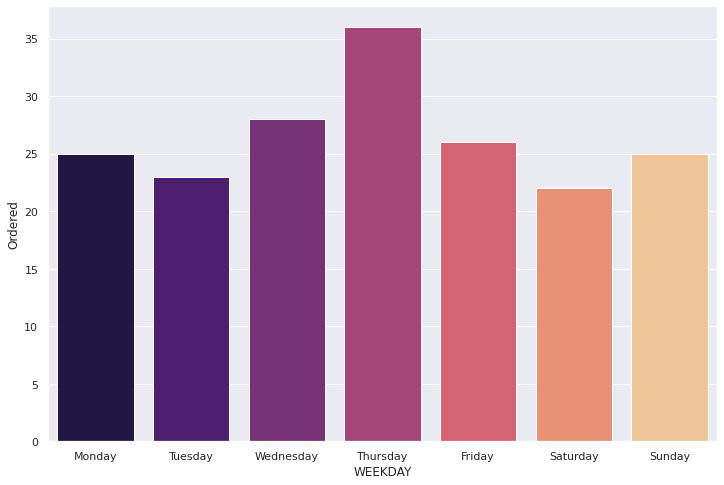

In [40]:
plt.subplots(figsize=(12,8))
sn.set_theme(style="darkgrid")
ax = sn.barplot(data = sales_by_wd, y = 'Ordered', x = sales_by_wd.index, palette = 'magma')
ax.set(xticklabels = weekdays_list)
ax.set(xlabel = 'WEEKDAY')

## Thursday is a shopping day